

Финальная оценка классификатора: 0.9459459459459459 при оптимальном k=9


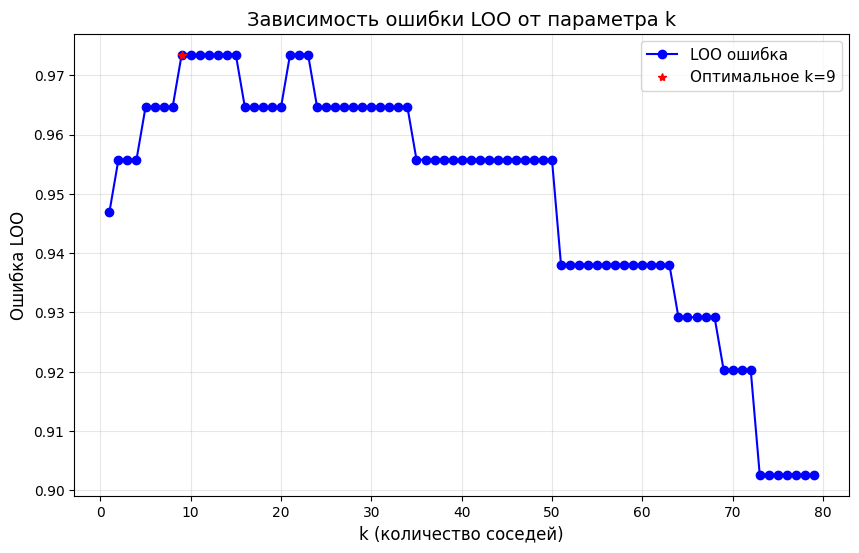

In [2]:
import numpy as np
from abc import ABC, abstractmethod
from typing import Optional, Tuple, Any, Iterator
import matplotlib.pyplot as plt

class Kernel(ABC):
    # Базовый класс для всех ядер. Реализует паттерн "Шаблонный метод"
    # через абстрактный compute(), который должны переопределять потомки
    
    @abstractmethod  
    def compute(self, r: float) -> float:
        pass
    
    def __call__(self, r: float) -> float:
        # Позволяет использовать объект ядра как функцию: kernel(r)
        return self.compute(r)
    
    def compute_batch(self, x: np.ndarray) -> np.ndarray:
        # Базовая реализация для пакетной обработки.
        # Потомки могут переопределять для оптимизации (векторизации)
        return np.array([self.compute(elem) for elem in x])
    

class EpanechnikovKernel(Kernel):
    def compute(self, r: float) -> float:
        # Ядро Епанечкова: (3/4)(1 - r²) при |r| ≤ 1, иначе 0
        # Оптимально по среднеквадратичной ошибке среди всех ядер
        if abs(r) <= 1:
            return (3.0 / 4.0) * (1.0 - r ** 2)
        return 0.0
    
    def compute_batch(self, x: np.ndarray) -> np.ndarray:
        # Переопределяем для векторизованной обработки (быстрее чем в базовом классе)
        return np.where(np.abs(x) <= 1, (3.0 / 4.0) * (1.0 - x ** 2), 0)
    
class DistanceMetric(ABC):
    # Базовый класс для метрик расстояния. Позволяет вычислять как одиночные,
    # так и пакетные расстояния единообразно
    
    @abstractmethod  
    def compute(self, x: np.ndarray, y: np.ndarray) -> float:
        pass
    
    def compute_batch(self, x: np.ndarray, X: np.ndarray) -> np.ndarray:
        # Базовая реализация через цикл. Потомки могут переопределять
        # для векторизованных вычислений (особенно важно для больших данных)
        return np.array([self.compute(x, x_train) for x_train in X])
    

class EuclideanMetric(DistanceMetric):
    def compute(self, x: np.ndarray, y: np.ndarray) -> float:
        return np.sqrt(np.sum((x - y) ** 2))
    
    def compute_batch(self, x: np.ndarray, X: np.ndarray) -> np.ndarray:
        # Векторизованная версия: вычисляем расстояния до всех точек сразу
        # через broadcasting. Работает значительно быстрее базовой реализации
        return np.sqrt(np.sum((X - x) ** 2, axis=1))

class BaseMetric(ABC):
     # Базовый класс для метрик качества.
     # Работет только с numpy.ndarray!!!
    @abstractmethod
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        #__call__ для вызова объекта как функции.
        #example: metric(y_true, y_pred)
        pass

class Accuracy(BaseMetric):
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        # Доля правильных ответов. 
        # y_true == y_pred → булев массив
        # mean() неявно преобразует True→1, False→0
        return np.mean(y_true == y_pred)

class ParzenWindowClassifier:
    def __init__(self, k: int = 5, metric: Optional[DistanceMetric] = None, kernel: Optional[Kernel] = None):
        self.k = k
        # Если метрика/ядро не заданы, используем стандартные
        self.metric = metric if metric else EuclideanMetric()
        self.kernel = kernel if kernel else EpanechnikovKernel()
        self.X_train = None
        self.y_train = None
        self.classes = None
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'ParzenWindowClassifier':
        #fit Обучаем классификатор(загружаем данные)
        self.X_train = X
        self.y_train = y
        #уникальные классы для классификации
        self.classes = np.unique(y)
        #Возвращаем себя для возможности цепочки вызовов(like sklearn)
        return self
    def _compute_distance(self, x: np.ndarray) -> np.ndarray:
        #функция для нахождения расстояние от точки до множества точек
        return self.metric.compute_batch(x, self.X_train)
    # TODO: Можно оптимизировать через quickselect вместо полной сортировки (O(n) вместо O(n log n))
    def _get_k_distance(self, x: np.ndarray) -> float:
        #Ищем дистанцию до k+1-ого соседа
        distance = self._compute_distance(x)
        distance = np.sort(distance)
        return distance[self.k]

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Возвращает numpy массив предсказаний
        # Если один объект, то оборачиваем в 2-мерный массив
        if X.ndim == 1:
            X = X.reshape(1, -1)
        predictions = np.zeros(len(X), dtype=self.y_train.dtype)
        for i, x in enumerate(X):
            predictions[i] = self._predict_one(x)
        
        return predictions
    def _predict_one(self, x: np.ndarray) -> Any:
        # Вычисляем ширину окна
        h = self._get_k_distance(x)
        if h == 0:
            weights = self.metric.compute_batch(x, self.X_train)
            weights = np.where(self.kernel.compute_batch(weights)==0, self.kernel.compute(0), 0)
        #Вычисляем веса(с учетом окна)
        else:
            weights = self.kernel.compute_batch(self.metric.compute_batch(x, self.X_train) / h)
        class_weights = {}
        for class_label in self.classes:
            # Создаем маску для объектов данного класса
            class_mask = (self.y_train == class_label)
            # Суммируем веса объектов этого класса
            class_weights[class_label] = np.sum(weights[class_mask])
        
        # Возвращаем класс с максимальным весом
        return max(class_weights, key=class_weights.get)
class LeaveOneOut:
    # Реализация LOO кросс-валидации - каждый объект по очереди становится тестовым
    
    def split(self, X: np.ndarray) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        # Генерирует индексы для train/test при LOO
        n_samples = len(X)
        for i in range(n_samples):
            # Все индексы кроме i - в train, i - в test
            train_ind = np.concatenate([np.arange(i), np.arange(i+1, n_samples)])
            test_ind = np.array([i])
            yield train_ind, test_ind

def cross_val_score(estimator, X: np.ndarray, y: np.ndarray, cv, scoring) -> float:
    # Вычисляет среднюю метрику качества на кросс-валидации
    # estimator, cv, scoring не аннотируем типами, т.к. могут быть разные реализации
    sum_scores = 0
    for train_ind, test_ind in cv.split(X):
        X_train, y_train = X[train_ind], y[train_ind]
        X_test, y_test = X[test_ind], y[test_ind]
        y_pred = estimator.fit(X_train, y_train).predict(X_test)
        score = scoring(y_pred, y_test)
        sum_scores += score
    return sum_scores / len(X)

def train_test_split(
    X: np.ndarray, 
    y: np.ndarray, 
    test_size: float = 0.25, 
    random_state: Optional[int] = 42, 
    shuffle: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Разбивает данные на обучающую и тестовую выборки
    
    n_test = int(len(X) * test_size)
    indices = np.arange(len(X))
    
    if shuffle:
        np.random.seed(random_state)
        # shuffle изменяет массив на месте(перемешивает)
        np.random.shuffle(indices)
    
    # Индексы для train/test
    ind_train = indices[n_test:]
    ind_test = indices[:n_test]
    
    X_train = X[ind_train]
    X_test = X[ind_test]
    y_train = y[ind_train]
    y_test = y[ind_test]

    return X_train, X_test, y_train, y_test

#////////////////////////////////////////////////////
#main
def plot_val_for_knn(scores, best_k):
    plt.figure(figsize=(10, 6))
    plt.plot([i for i in range(1, 80)], scores, 'b-o', label="LOO ошибка")
    plt.plot(best_k, scores[best_k - 1], 'r*', label=f"Оптимальное k={best_k}")
    plt.xlabel('k (количество соседей)', fontsize=12)
    plt.ylabel('Ошибка LOO', fontsize=12)
    plt.title('Зависимость ошибки LOO от параметра k', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
def compute_all_scores_for_knn(X, y, cv, scoring):
    scores = []
    for k in range(1, 80):
        clf = ParzenWindowClassifier(k=k)
        cv = LeaveOneOut()
        score = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        scores.append(score)
    return scores

def search_best_k(scores):
    return np.argmax(scores) + 1

def load_and_prepare_data():
    from sklearn.datasets import load_iris
    iris = load_iris()
    X = iris.data # массив numpy
    y = iris.target # массив numpy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)
    return X_train, y_train, X_test, y_test 


X_train, y_train, X_test, y_test = load_and_prepare_data()
scores = compute_all_scores_for_knn(X_train, y_train, cv=LeaveOneOut(), scoring=Accuracy())
best_k = search_best_k(scores)
plot_val_for_knn(scores, best_k)
clf = ParzenWindowClassifier(k=best_k)
y_pred = clf.fit(X_train, y_train).predict(X_test)
final_score = Accuracy()(y_test, y_pred)

print()
print()
print(f"Финальная оценка классификатора: {final_score} при оптимальном k={best_k}")